# EEG PreProcessing for Hyper Alignment Project

Subjects with issues:
- A00062329
    - Error in Event Management
- A00062408
    - Error in Event Management (seemingly different from above)
- A00062453
    - Error in Event Management (different again?)

In [1]:
%matplotlib inline

import os
import csv
import pickle

from copy import deepcopy
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne

from mne import set_log_level
from mne.event import define_target_events
from mne.preprocessing import ICA

from autoreject import AutoReject
from faster import faster_bad_channels

In [2]:
# Set log level to quieten MNE
set_log_level('CRITICAL')

## Load Data

Dataset description:

The EEG data used is a database collected and made available by the Child Mind Institute.

It is part of the Multimodal Resource for Studying Information Processing in the Developing Brain (MIPDB) database.

MIPDB Link: http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/

EEG Data Link: http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/eeg.html

In [3]:
# Set paths
BASE_PATH = '/Users/jarrodmhicks/Desktop/HyperEEG_Project/Data/'
DATA_PATH = os.path.join(BASE_PATH, 'raw')
PROC_PATH = os.path.join(BASE_PATH, 'proc')
ICA_PATH  = os.path.join(BASE_PATH, 'ica')

In [4]:
# Settings
N_EPOCHS = 40

In [5]:
# Get a list of all available subjects
subnums = [file for file in os.listdir(DATA_PATH) if file[0] is not '.']

In [6]:
# Load the file that maps all the subject files to task type
fms = pd.read_csv('file_mappings.csv', header=None, names=['SUBNUM', 'FILE', 'TASK'])

In [20]:
# Set the current subject number
subnum = 'A00062453'
# subnum = 'A00062165'
# subnum = 'A00062408'

# Create the full subject path
subj_path = os.path.join(DATA_PATH, subnum, 'EEG', 'raw', 'raw_format')

# Select the files for the contrast task, from the file mapping directory
subj_files = list(fms.loc[(fms["SUBNUM"] == subnum) & (fms["TASK"] == 'contrast')]["FILE"].values)

if len(subj_files) < 2:
    print('Subject does not have enough data')
#     continue

Subject does not have enough data


In [8]:
# Check how many files are available for this subject on specified task
print('# of task files:', len(subj_files))

# of task files: 1


In [9]:
# Load all available task specific files, and concatenate together
raws = []
for subj_file in subj_files:
    raws.append(mne.io.read_raw_egi(os.path.join(subj_path, subj_file), preload=True, verbose=False))

In [10]:
# Check event codes present from the file
set(mne.find_events(raws[0])[:, 2])

{1, 2, 3, 4, 5}

## Set up Data


### Montage

The following EEG sensors did not have a position specified in the selected montage: ['E129']. Their position has been left untouched.


<ipython-input-11-78e2a63dc0a7>:5: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['E129']. Their position has been left untouched.
  raw.set_montage(montage)


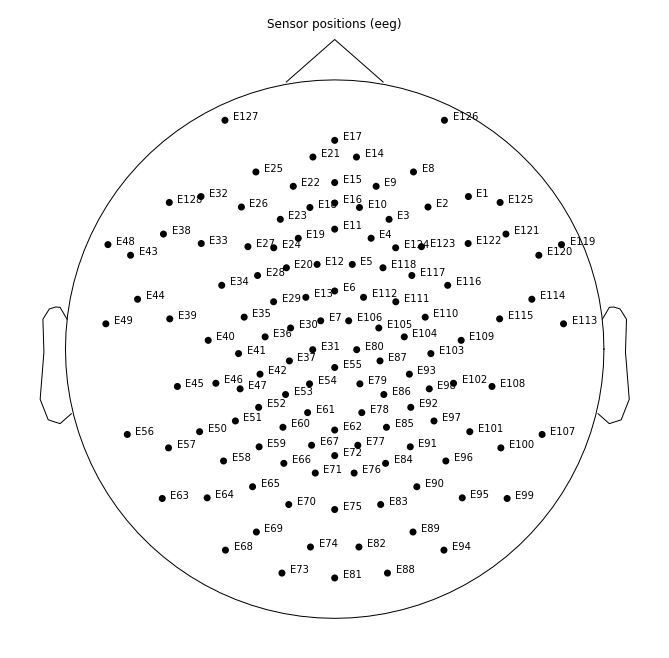

In [11]:
# Load standard montage, drop misc channels, and display channel locations
montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=raws[0].ch_names)

for raw in raws:
    raw.set_montage(montage)
    raw.drop_channels(raw.ch_names[128:-1])
    
fig, ax = plt.subplots(figsize=[9, 9]);
raws[0].plot_sensors(show_names=True, axes=ax);

## Inspect data

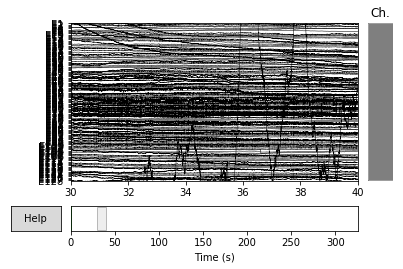

In [12]:
# Print out a small snippet of data
raws[0].plot(events=None, duration=10., start=30., n_channels=128);

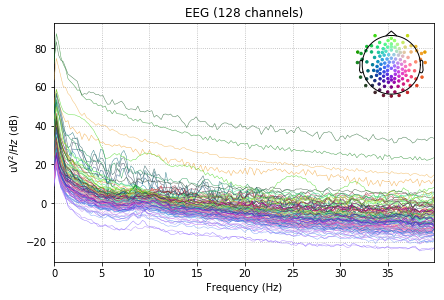

In [13]:
# Check the power spectrum of each channel
raws[0].plot_psd(tmin=30, fmin=0, fmax=40, dB=True);

## Pre-Processing

Run pre-processing on the data. 

In [14]:
# High pass filter and sanity check
for raw in raws:
    raw.filter(l_freq=0.1, h_freq=30., fir_design='firwin', verbose=False)

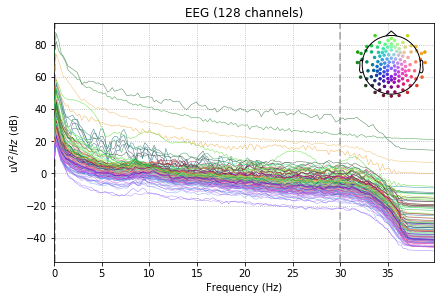

In [15]:
raws[0].plot_psd(tmin=30, fmin=0, fmax=40, dB=True);

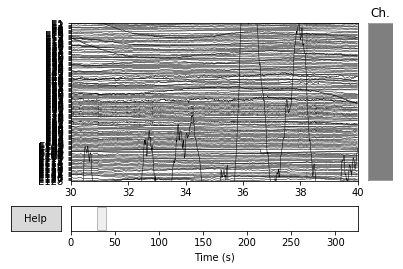

In [16]:
# Combine raw objects into a new, single raw object, and check filtering in time domain
raw = mne.concatenate_raws(raws)
raw.plot(events=None, duration=10., start=30., n_channels=128);

### Events & Epoching

Event code descriptions:
- 3 :  5  = start trial
- 4 :  8  = Target ON left
- 5 :  9  = Target ON right
- 1 : 12  = button press left
- 2 : 13  = button press right

Counter({3: 25, 1: 18, 5: 12, 4: 12, 2: 9})


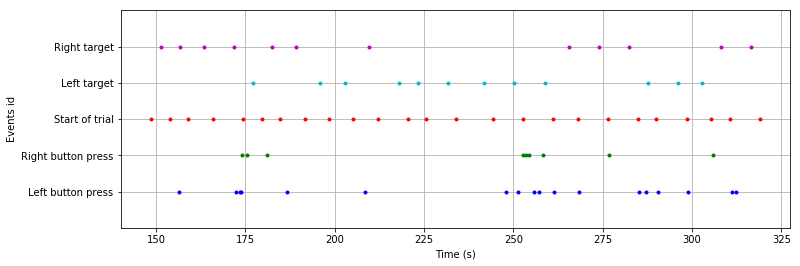

In [17]:
# Check events and codes
events = mne.find_events(raw, verbose=False)
print(Counter(events[:, 2]))

fig, ax = plt.subplots(figsize=[12, 4])
_ = mne.viz.plot_events(events, raw.info['sfreq'], axes=ax, show=False)
ax.set_yticklabels(['Left button press', 'Right button press', 'Start of trial', 'Left target', 'Right target']);

## Construct new epochs based on combination of stimuli and correct responses

In [18]:
# Event code descriptions
trgts = [4, 5]
rspns = [1, 2]

sfreq = raw.info['sfreq']  # sampling rate

tmin = -2.  # trials leading to very early responses will be rejected
tmax = 0.  # ignore face stimuli followed by button press later than 2 s

correct_trials = [21, 22] # new event ids for correct responses.

new_events = [] # list of new event objects
for idx in range(2):
    tmp, _ = define_target_events(events, rspns[idx], trgts[idx], sfreq, tmin, tmax, correct_trials[idx], fill_na=None)
    new_events.append(tmp)

# Collapse new events into an array
new_events = np.concatenate((np.array(new_events[0]), np.array(new_events[1])), axis=0)
new_event_ids = dict(left=21, right=22)

if not np.any(new_events):
    print('Subject has no correct trials...')
    continue
elif new_events.shape[1] < N_EPOCHS:
    print('Subject has too few trials for analysis')
    continue

print(Counter(new_events[:, -1]))

ValueError: all the input arrays must have same number of dimensions

In [19]:
new_events

[array([[125588,      0,     21]]), array([], dtype=float64)]

In [ ]:
# Epoch data and equalize counts
baseline = (0.5, None)
epochs = mne.Epochs(raw, new_events, new_event_ids, tmin=-1., tmax=1., picks=None,
                    baseline=baseline, reject=None,
                    preload=True, verbose=False)

## Automatically detect and mark bad channels

/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 8192 is greater than input length  = 6006, using nperseg = 6006
  .format(nperseg, input_length))


['E104', 'E14', 'E25']


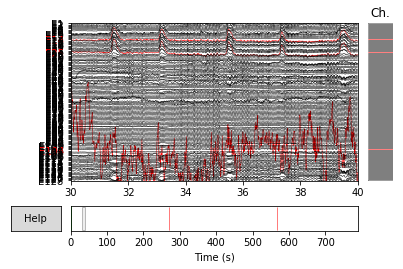

In [28]:
bad_channels = faster_bad_channels(epochs, thres=5)
raw.info['bads'] = bad_channels
epochs.info['bads'] = bad_channels
print(bad_channels)
raw.plot(events=None, duration=10., start=30., n_channels=128, bad_color='r');

### Re-reference

In [30]:
# Set the average reference
raw.set_eeg_reference('average')

<RawEGI  |  A00062165005.raw, n_channels x n_times : 129 x 394657 (789.3 sec), ~388.7 MB, data loaded>

## Remove blink artifacts via ICA

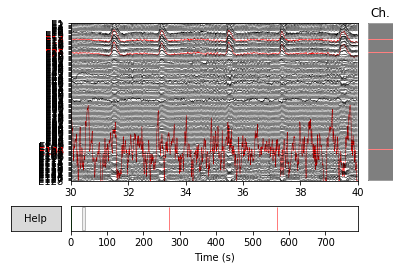

In [31]:
# Filter above 1 Hz and recreate epochs
raw_hpf = deepcopy(raw)
raw_hpf.filter(l_freq=1., h_freq=None, fir_design='firwin', verbose=False)
raw_hpf.plot(events=None, duration=10., start=30., n_channels=128, bad_color='r');

In [32]:
# Epoch the highpass filtered data
epochs_hpf = mne.Epochs(raw_hpf, new_events, new_event_ids, tmin=-1., tmax=1., picks=None,
                        baseline=baseline, reject=None,
                        preload=True, verbose=False)

The events passed to the Epochs constructor are not chronologically ordered.


<ipython-input-32-5ad24e02126a>:4: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  preload=True, verbose=False)


In [33]:
# Run ICA on epochs
ica = ICA(random_state=1)
ica.fit(epochs_hpf)

<ICA  |  epochs decomposition, fit (fastica): 6006 samples, 125 components, channels used: "eeg">

['E8', 'E21']


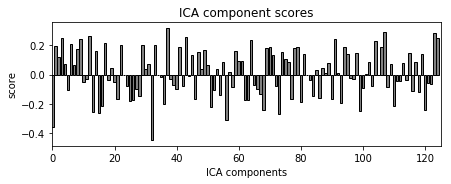

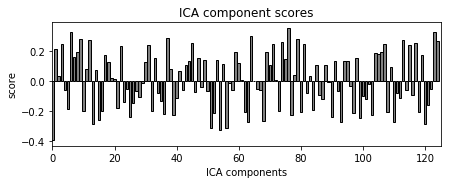

In [34]:
# Find ICA components that are correlated with likely eye activity, and mark then as bad
eog_chs = ['E8', 'E14','E21','E25']
eog_chs = [ch for ch in eog_chs if ch not in raw.info['bads']]
print(eog_chs)

bad_ica_comps = []
for ch in eog_chs:
    inds, scores = ica.find_bads_eog(raw_hpf, ch_name=ch, threshold=3, l_freq=1, h_freq=8, verbose=False)
    bad_ica_comps.extend(inds)
    ica.plot_scores(scores, exclude=inds)

bad_ica_comps = list(set(bad_ica_comps))
ica.exclude = bad_ica_comps

In [35]:
# Save out the ICA solution
#ica.save(os.path.join(ICA_PATH, subnum + '-ica.fif'))

In [38]:
# Check ICA components
if len(bad_ica_comps) > 0:
    fica.plot_components(picks=np.array(bad_ica_comps))

### Apply ICA decomp to data and check

In [39]:
# Apply ICA to the 
epochs = ica.apply(epochs)
raw = ica.apply(raw)

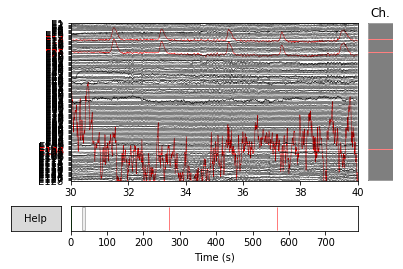

In [40]:
# Check a plot of the ICA corrected raw data
raw.plot(events=None, duration=10., start=30., n_channels=128, bad_color='r');

In [41]:
# Save out a copy of the raw data with ICA applied
#raw.save(os.path.join(PROC_PATH, subnum + '-raw.fif'), overwrite=True)

In [42]:
# Compute the evoked response (average to get ERPs)
evoked = epochs.average()

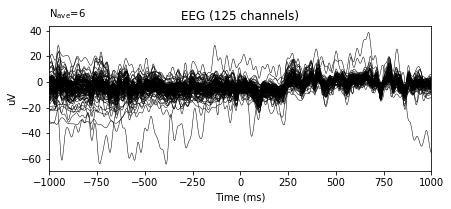

In [43]:
# Plot the evoked response
evoked.plot(time_unit='ms');

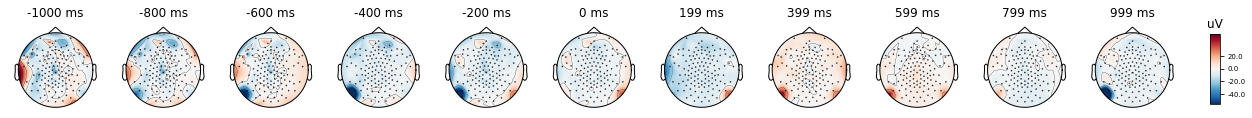

In [44]:
# Check the topography of the evoked response
evoked.plot_topomap(times=np.arange(-1., 1.1, 0.2), time_unit='ms');

### AutoReject

In [45]:
# Initialize autoreject object and run
ar = AutoReject(n_jobs=4, random_state=1, verbose=False, cv=3)
epochs, rej_log = ar.fit_transform(epochs, return_log=True)

Computing thresholds ...


In [46]:
# Save out autoreject log, as a pickled object
#pickle.dump(rej_log, open("test.p", "wb"))

# Note: can load the rej_log back in as follows
#rej_log = pickle.load(open('test.p', 'rb'))

## Save preprocessed epochs object to file

In [47]:
epochs

<Epochs  |   4 events (all good), -1 - 1 sec, baseline [0.5, None], ~4.3 MB, data loaded,
 'left': 1
 'right': 3>

In [48]:
# Equalize the number of events per condition, within the subject
epochs.equalize_event_counts(new_event_ids, method='mintime')

ValueError: x and y arrays must have at least 2 entries

In [ ]:
# Same kind of event checking
if len(epochs) < N_EPOCHS:
    print('Subject has too few trials for analysis')
    continue

In [ ]:
# Save out the pre-processed epochs file
#epochs.save(os.path.join(PROC_PATH, subnum + '_preprocessed-epo.fif'))

# Analyses

At this point, the rest becomes specific to the particular analyses that need to be done.

In [ ]:
# Calcualte ERPs
epochs.average().plot(time_unit='ms');